# Imports

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

# Configs

In [2]:
INPUT_PATH = 'datasets/'
OUTPUT_PATH = 'results/ridge_predictions.parquet'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

FEATURE_LIST = [
                'previous_interval',
                'previous_day_interval', 
                'previous_2day_interval',
                'previous_3day_interval',
                'previous_4day_interval',
                'previous_5day_interval',
                'previous_6day_interval',
                'previous_8day_interval',
                'previous_9day_interval',
                'previous_10day_interval',
                'previous_11day_interval',
                'previous_12day_interval',
                'previous_13day_interval',

                'previous_2week_interval',
                'previous_week_interval', 
                'Day_of_month', 
                'Day_of_week'
                ]

TEST_START_DATE = '2023-04-1'


# Data preparation


## Load Data

In [3]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path)
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [4]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

In [5]:
print(f'rides dataframe shape : {rides_df.shape}')
rides_df.head()

rides dataframe shape : (12672629, 3)


,tpep_pickup_datetime,PULocationID,PU_date
0,2023-01-01 00:32:10,161,2023-01-01
1,2023-01-01 00:55:08,43,2023-01-01
2,2023-01-01 00:25:04,48,2023-01-01
3,2023-01-01 00:03:48,138,2023-01-01
4,2023-01-01 00:10:29,107,2023-01-01


## Labeling

In [6]:
def extract_hours(dataset):
    dataset = dataset.sort_values('tpep_pickup_datetime')
    dataset['hour'] = dataset['tpep_pickup_datetime'].dt.hour
    
    bins = [-1, 2, 5, 8, 11, 14, 17, 20, 23]
    labels = [0, 3, 6, 9, 12, 15, 18, 21]
    dataset['time_of_day'] = pd.cut(dataset['hour'], bins=bins, labels=labels, include_lowest=True)
    dataset = dataset.reset_index(drop = True)
    return dataset

In [7]:
def labeling(dataset):
    dataset = extract_hours(dataset)
    
    dataset_labels = (
        dataset
        .groupby(['PULocationID', 'PU_date', 'time_of_day'])['time_of_day']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'PU_date', 'time_of_day'], ascending=[True, True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date', 'time_of_day' : 'Time'})
    )

    locations = pd.DataFrame(dataset_labels['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])
    times = pd.DataFrame(dataset_labels['Time'].unique(), columns=['Time'])

    location_date_time_df = (
        locations
        .merge(dates, how='cross')
        .merge(times, how='cross')
        .sort_values(['Location', 'Date', 'Time'], ascending=[True, True, True])
        .reset_index(drop=True)
    )

    labels_df = (
        location_date_time_df
        .merge(dataset_labels, how='left', on=['Location', 'Date', 'Time'])
        .fillna(value=0)
    )

    return labels_df

In [8]:
labeled_df = labeling(rides_df)

In [9]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (251520, 4)


,Location,Date,Time,Demand
0,1,2023-01-01,0,0
1,1,2023-01-01,3,1
2,1,2023-01-01,6,1
3,1,2023-01-01,9,1
4,1,2023-01-01,12,13


## Add Feature

In [10]:
def feature_engineering(dataset):
    dataset['previous_interval'] = dataset.groupby(['Location'])['Demand'].shift(1)
    dataset['previous_day_interval'] = dataset.groupby(['Location'])['Demand'].shift(1*8)
    dataset['previous_2day_interval'] = dataset.groupby(['Location'])['Demand'].shift(2*8)
    dataset['previous_3day_interval'] = dataset.groupby(['Location'])['Demand'].shift(3*8)
    dataset['previous_4day_interval'] = dataset.groupby(['Location'])['Demand'].shift(4*8)
    dataset['previous_5day_interval'] = dataset.groupby(['Location'])['Demand'].shift(5*8)
    dataset['previous_6day_interval'] = dataset.groupby(['Location'])['Demand'].shift(6*8)
    dataset['previous_week_interval'] = dataset.groupby(['Location'])['Demand'].shift(7*8)
    dataset['previous_8day_interval'] = dataset.groupby(['Location'])['Demand'].shift(8*8)
    dataset['previous_9day_interval'] = dataset.groupby(['Location'])['Demand'].shift(9*8)
    dataset['previous_10day_interval'] = dataset.groupby(['Location'])['Demand'].shift(10*8)
    dataset['previous_11day_interval'] = dataset.groupby(['Location'])['Demand'].shift(11*8)
    dataset['previous_12day_interval'] = dataset.groupby(['Location'])['Demand'].shift(12*8)
    dataset['previous_13day_interval'] = dataset.groupby(['Location'])['Demand'].shift(13*8)
    dataset['previous_2week_interval'] = dataset.groupby(['Location'])['Demand'].shift(14*8)

    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek   
    dataset['Day_of_month'] = dataset['Date'].dt.day
    
    return dataset

In [11]:
features_df = feature_engineering(labeled_df)
features_df.dropna(inplace = True)

In [12]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (222176, 21)


,Location,Date,Time,Demand,previous_interval,previous_day_interval,previous_2day_interval,previous_3day_interval,previous_4day_interval,previous_5day_interval,...,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval,Day_of_week,Day_of_month
112,1,2023-01-15,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,6,15
113,1,2023-01-15,3,2,0.0,0.0,1.0,2.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0,6,15
114,1,2023-01-15,6,1,2.0,1.0,2.0,0.0,2.0,0.0,...,3.0,1.0,0.0,2.0,2.0,2.0,4.0,1.0,6,15
115,1,2023-01-15,9,0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,2.0,0.0,2.0,4.0,1.0,6,15
116,1,2023-01-15,12,8,0.0,0.0,1.0,2.0,2.0,1.0,...,2.0,1.0,3.0,4.0,3.0,7.0,11.0,13.0,6,15


## Split Train and Test Data

In [13]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [14]:
train_df, test_df = train_test_splitting(features_df, TEST_START_DATE)

In [15]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (159296, 21)


,Location,Date,Time,Demand,previous_interval,previous_day_interval,previous_2day_interval,previous_3day_interval,previous_4day_interval,previous_5day_interval,...,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval,Day_of_week,Day_of_month
112,1,2023-01-15,0,0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,6,15
113,1,2023-01-15,3,2,0.0,0.0,1.0,2.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0,6,15
114,1,2023-01-15,6,1,2.0,1.0,2.0,0.0,2.0,0.0,...,3.0,1.0,0.0,2.0,2.0,2.0,4.0,1.0,6,15
115,1,2023-01-15,9,0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,2.0,0.0,2.0,4.0,1.0,6,15
116,1,2023-01-15,12,8,0.0,0.0,1.0,2.0,2.0,1.0,...,2.0,1.0,3.0,4.0,3.0,7.0,11.0,13.0,6,15


In [16]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (62880, 21)


,Location,Date,Time,Demand,previous_interval,previous_day_interval,previous_2day_interval,previous_3day_interval,previous_4day_interval,previous_5day_interval,...,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval,Day_of_week,Day_of_month
720,1,2023-04-01,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,1
721,1,2023-04-01,3,1,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,5,1
722,1,2023-04-01,6,1,1.0,0.0,3.0,0.0,0.0,0.0,...,3.0,0.0,5.0,2.0,0.0,1.0,1.0,7.0,5,1
723,1,2023-04-01,9,0,1.0,2.0,2.0,3.0,3.0,0.0,...,2.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0,5,1
724,1,2023-04-01,12,1,0.0,5.0,4.0,0.0,5.0,2.0,...,3.0,2.0,4.0,0.0,0.0,3.0,9.0,2.0,5,1


# Model Training

## **Ridge Regression**

### Model Tuning

In [17]:
def grid_search(model, test_parameters, train_data, cv = None, feature_list = FEATURE_LIST):
    gs = GridSearchCV(
        estimator = model, 
        param_grid = test_parameters, 
        scoring = 'neg_root_mean_squared_error', 
        cv = cv, 
        n_jobs = -1
        )
    
    gs.fit(train_data[feature_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [18]:
model = Ridge()
best_params, best_score = grid_search(
    model, 
    {'alpha':[1, 10, 100]},
    train_df, 
    cv = 5, 
    feature_list = FEATURE_LIST
    )

print(best_params, best_score)

{'alpha': 100} -20.381785647434505


### Prediction

In [19]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])


    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [20]:
model = Ridge(**best_params)
train_prediction_df , test_prediction_df  = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [21]:
def add_day_of_year(data):
    data['day_year'] = 0
    start_date = data['Date'].min()

    for index, row in data.iterrows():

        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        data.at[index, 'day_year'] = day_number
    return data

In [22]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):


    train_data = add_day_of_year(train_data)
    test_data = add_day_of_year(test_data)

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

C:\Users\bardia\AppData\Local\Temp\ipykernel_12916\2975102461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_year'] = 0
C:\Users\bardia\AppData\Local\Temp\ipykernel_12916\2975102461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_year'] = 0
C:\Users\bardia\AppData\Local\Temp\ipykernel_12916\2246591508.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

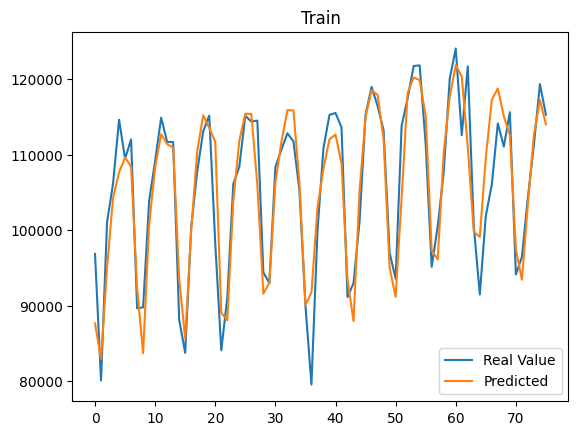

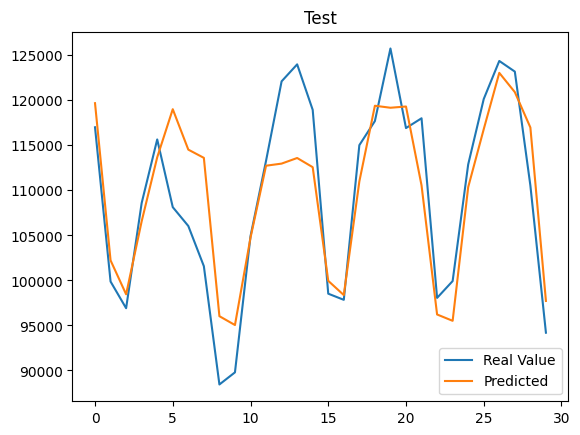

In [23]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [24]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [25]:
def evaluation(model_name, train_data, test_data, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_data['Demand'], train_prediction_df)

    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_data['Demand'], test_prediction_df)


In [26]:
evaluation('Ridge Regression', train_df, test_df, train_prediction_df, test_prediction_df)

Ridge Regression train scores:
MAE : 6.363241398122363
MSE : 450.4450775675966
MAPE : 1183559070204504.5
Ridge Regression test scores:
MAE : 6.586878935654306
MSE : 430.90301321027147
MAPE : 1222668201031586.5


# File Saving

In [27]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [28]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [29]:
labeled_prediction_df = prediction_labeling(test_prediction_df, test_df)

C:\Users\bardia\AppData\Local\Temp\ipykernel_12916\1857597426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_prediction_df['Predicted_demand'] = pred_df


In [30]:
print(f'labeled prediction dataframe shape : {labeled_prediction_df.shape}')
labeled_prediction_df.head()

labeled prediction dataframe shape : (62880, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,0.844770
1,1,2023-04-01,1.336940
2,1,2023-04-01,3.997402
3,1,2023-04-01,2.644936
4,1,2023-04-01,3.952247


In [31]:
save_predictions(labeled_prediction_df, OUTPUT_PATH)